# Naomi Kaduwela
# Assignment 1 - Due 5/8/2019
## Simple neural network
Build a simple neural network from first principles and understand the underlying mechanisms of how the system works.

In this assignment, students will:
- Build a simple neural network from basic operations using numpy
- Implement the core neural network in 9 simple lines of code
- Make improvements to the simple neural network
- Visualize the network to understand weights, activations, gradients and class separation power

In [138]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [139]:
# Load MNIST dataset
from tensorflow.keras.datasets import mnist
# X is an array of 60,000 28x28 black and white images with pixel values from 0-255
# Y is an array of 60,000 labels with values from 0-9 denoting the image class
(X, Y), (_, _) = mnist.load_data()

Text(0.5,1,'Class: 0')

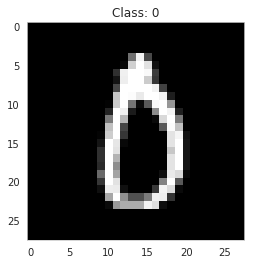

In [140]:
# Show some random example images from X
random_digit = np.random.randint(0, len(X) - 1)
plt.imshow(X[random_digit], cmap='gray')
# Show image class
plt.title('Class: %01d' % Y[random_digit])

In [141]:
# Do some basic transforms of data

# We want the pixels in X to have values between 0-1. We'll need to cast to float32 to support the range 0-1.
X = X.astype('float32') / 255.0

# As mentioned in lecture 3, we'll need to flatten X to input it into our basic neural network
X = X.reshape((len(X), -1)).T

# Y should be a 1-hot vector with a 1 indicating the digit class and 0 elsewhere
T = np.zeros((len(Y), 10), dtype='float32').T                   
for i in range(len(Y)): 
    T[Y[i], i] = 1

# Weight definitions
Let's define our basic 3-layer network.

$W1, W2, W3$ are the randomly initialized weight matrices.

We cast to float32 for efficiency as the default type for np.random.rand is 64 bit, and that's slower.

In [142]:
#%% Setup: 784 -> 256 -> 128 -> 10
W1 = 2*np.random.rand(784, 256).astype('float32').T - 1
W2 = 2*np.random.rand(256, 128).astype('float32').T - 1
W3 = 2*np.random.rand(128,  10).astype('float32').T - 1

In [143]:
# Define basic sigmoid activation
def sigmoid(x): return 1.0/(1.0 + np.e**-x)

# Add other activation functions here


# Core functions
## The next 4 functions are the heart of a basic neural network
- Forward pass: calculates activations
- Backward pass: calculates the gradients
- Update weights: applies the gradient updates to the weight matrices
- Calculate loss: reports how we're doing

In [144]:
def forward_pass(X, W1, W2, W3):
    L1 = sigmoid(W1.dot(X))
    L2 = sigmoid(W2.dot(L1))
    L3 = sigmoid(W3.dot(L2))
    return L1, L2, L3

In [145]:
def backward_pass(L1, L2, L3, W1, W2, W3):
    dW3 = (L3 - T) * L3*(1 - L3)
    dW2 = W3.T.dot(dW3)*(L2*(1-L2))
    dW1 = W2.T.dot(dW2)*(L1*(1-L1))    
    return dW1, dW2, dW3

In [146]:
def update_weights(lr, W1, W2, W3, dW1, dW2, dW3, X, L1, L2):
    W3 -= lr*np.dot(dW3, L2.T)
    W2 -= lr*np.dot(dW2, L1.T)
    W1 -= lr*np.dot(dW1, X.T)
    return W1, W2, W3

In [147]:
# Monitoring variables
accuracies = []
losses     = []
mean_activ = []
hw1, hw2, hw3 = [], [], []


In [148]:
def calculate_loss():
    global losses
    loss = np.sum((L3 - T)**2)/len(T.T)
    losses.append(loss)
    #print("[%04d] MSE Loss: %0.6f" % (i, loss)) 

In [149]:
def accuracy():
    global L3, accpct, accuracies
    predictions = np.zeros(L3.shape, dtype='float32')
    for j, m in enumerate(np.argmax(L3.T, axis=1)): predictions[m,j] = 1
    acc = np.sum(predictions*T)
    accpct = 100*acc/X.shape[1]
    accuracies.append(accpct)

In [150]:
def hw_update():
    global L1, L2, L3, dW1, dW2, dW3, hw1, hw2, hw3
    uw1, uw2, uw3 = np.dot(dW1, X.T), np.dot(dW2, L1.T), np.dot(dW3, L2.T)
    hw1.append(lr*np.abs(uw1).mean()), hw2.append(lr*np.abs(uw2).mean()), hw3.append(lr*np.abs(uw3).mean())

In [151]:
# Helper function to draw confusion matrix
def confusion_matrix():
    global X, L1, L2, L3, W1, W2, W3, dW1, dW2, dW3, accuracies, losses, accpct
    import seaborn
    os.makedirs('train', exist_ok=True)
    predictions = np.zeros(L3.shape, dtype='float32')
    for j, m in enumerate(np.argmax(L3.T, axis=1)): predictions[m,j] = 1
    acc = np.sum(predictions*T)
    accpct = 100*acc/X.shape[1]
    # accuracies.append(accpct)   

    data = np.zeros((10,10,))
    for z, c in enumerate(np.argmax(T.T, axis=1)): data[c][np.argmax(predictions.T[z])] += 1
    for z, s in enumerate(data.sum(axis=0)): data[:,z] /= (s + 1e-5)
    seaborn.set_style("whitegrid", {'axes.grid' : False})
    seaborn.heatmap(data, annot=data*100, fmt='0.0f', cmap='Wistia')
    plt.xlabel('Actual'), plt.ylabel('Predicted'), plt.title('Confusion matrix (ACC %0.2f%%)' % accpct)
    plt.savefig(os.path.join('train', 'confusion-%03d-%r.png' % (i,lr)))                               # edited train function name to include learning rate 
    #plt.savefig(os.path.join('train', 'tsne-%03d-%r-%r.png' % (i, k,lr)))
    plt.show(), plt.close()

In [152]:
# Helper function to visualize training
def triple_plot():
    global X, L1, L2, L3, W1, W2, W3, dW1, dW2, dW3, c, losses, accpct, mean_activ, hw1, hw2, hw3
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,3))
    testi = np.random.choice(range(60000))
    ax1.imshow(X.T[testi].reshape(28,28), cmap='gray')
    ax1.set_xticks([]), ax1.set_yticks([])
    cls = np.argmax(L3.T[testi])
    ax1.set_title("Prediction: %d confidence=%0.2f" % (cls, L3.T[testi][cls]/np.sum(L3.T[testi])))

    ax2.plot(losses, color='blue')
    ax2.set_title("Loss"), ax2.set_yscale('log')
    ax3.plot(accuracies, color='blue')
    ax3.set_ylim([0, 100])
    ax3.axhline(90, color='red', linestyle=':')     # Aim for 90% accuracy in 200 epochs        
    ax3.set_title("Accuracy: %0.2f%%-%03d-%r" % (accpct,i, lr))
    #ax3.set_title("Accuracy: %0.2f%%-%03d-%r" % (accpct,i, k))
    plt.show(), plt.close()

    fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12)) = plt.subplots(3, 4, figsize=(10,10))
    ax1.imshow(np.reshape(L1.mean(axis=1), (16, 16,)), cmap='gray', interpolation='none'), ax1.set_title('L1 $\mu$=%0.2f $\sigma$=%0.2f' % (L1.mean(), L1.std()))
    ax2.imshow(np.reshape(L2.mean(axis=1), (16, 8,)),  cmap='gray', interpolation='none'), ax2.set_title('L2 $\mu$=%0.2f $\sigma$=%0.2f' % (L2.mean(), L2.std()))
    ax3.imshow(np.reshape(L3.mean(axis=1), (10, 1,)),  cmap='gray', interpolation='none'), ax3.set_title('L3 $\mu$=%0.2f $\sigma$=%0.2f' % (L3.mean(), L3.std())), ax3.set_xticks([])
    activations = np.concatenate((L1.flatten(), L2.flatten(), L3.flatten()))
    try:
        ax4.hist(activations)
    except ValueError:
        pass
    ax4.set_title('Activation histogram')

    ax5.imshow(np.reshape(W1.mean(axis=0), (28, 28,)), cmap='gray', interpolation='none'), ax5.set_title('W1 $\mu$=%0.2f $\sigma$=%0.2f' % (W1.mean(), W1.std()))
    ax6.imshow(np.reshape(W2.mean(axis=0), (16, 16,)), cmap='gray', interpolation='none'), ax6.set_title('W2 $\mu$=%0.2f $\sigma$=%0.2f' % (W2.mean(), W2.std()))
    ax7.imshow(np.reshape(W3.mean(axis=0), (16, 8, )), cmap='gray', interpolation='none'), ax7.set_title('W3 $\mu$=%0.2f $\sigma$=%0.2f' % (W3.mean(), W3.std())), ax7.set_xticks([])
    ax8.plot(accuracies, color='blue'), ax8.set_title("Accuracy: %0.2f%%-%03d-%r" % (accpct,i,lr)), ax8.set_ylim(0, 100)

    uw1, uw2, uw3 = np.dot(dW1, X.T), np.dot(dW2, L1.T), np.dot(dW3, L2.T)
    hw1.append(lr*np.abs(uw1).mean()), hw2.append(lr*np.abs(uw2).mean()), hw3.append(lr*np.abs(uw3).mean())
    ax9.imshow(np.reshape(uw1.sum(axis=0),  (28, 28,)), cmap='gray', interpolation='none'), ax9.set_title ('$\Delta$W1: %0.2f E-5' % (1e5 * lr * np.abs(uw1).mean()), color='r')
    ax10.imshow(np.reshape(uw2.sum(axis=0), (16, 16,)), cmap='gray', interpolation='none'), ax10.set_title('$\Delta$W2: %0.2f E-5' % (1e5 * lr * np.abs(uw2).mean()), color='g')
    ax11.imshow(np.reshape(uw3.sum(axis=0), (16, 8, )), cmap='gray', interpolation='none'), ax11.set_title('$\Delta$W3: %0.2f E-5' % (1e5 * lr * np.abs(uw3).mean()), color='b'), ax11.set_xticks([])    
    ax12.plot(hw1, color='r', label='dW1'), ax12.plot(hw2, color='g', label='dW2'), ax12.plot(hw3, color='b', label='dW3'), ax12.set_title('Weight update magnitude')
    ax12.legend(loc='upper right'), ax12.set_yscale('log')

    plt.suptitle("Weight and update visualization ACC: %0.2f%% LR=%0.8f" % (accpct, lr))
    plt.savefig(os.path.join('train', 'train-%03d-%r.png' % (i,lr)))                     # edited train function name to include learning rate 
    #plt.savefig(os.path.join('train', 'tsne-%03d-%r-%r.png' % (i, k,lr)))
    plt.show(), plt.close()

In [153]:
# Helper function to visualize via T-SNE
def tsne_viz():
    global X, L1, L2, L3, W1, W2, W3, dW1, dW2, dW3, accuracies, losses
    from matplotlib import cm
    import sklearn.manifold
    colors = iter(cm.rainbow(np.linspace(0, 1, 10)))
    X_embedded = sklearn.manifold.TSNE(n_components=2).fit_transform(L2.T[:500])
    for digit in range(10):
        xx = X_embedded[Y[:500] == digit, 0]
        yy = X_embedded[Y[:500] == digit, 1]
        plt.scatter(xx, yy, c=[next(colors)], label=digit)
        t = plt.text(np.median(xx), np.median(yy), digit, fontsize=24)
        t.set_bbox({'facecolor': 'white', 'alpha': 0.75})
    plt.title('T-SNE viz - Accuracy: %0.2f%%' % accpct), plt.legend()            
    plt.savefig(os.path.join('train', 'tsne-%03d-%r.png' % (i, lr)))                     # edited train function name to include learning rate 
    #plt.savefig(os.path.join('train', 'tsne-%03d-%r-%r.png' % (i, k,lr))) 
    plt.show(), plt.close()

In [154]:
# temp_accuracies = []

# Helper function to draw confusion matrix
# def accuracy():
#    global X, L1, L2, L3, W1, W2, W3, dW1, dW2, dW3, temp_accpct, temp_accuracies
#    import seaborn
#    os.makedirs('train', exist_ok=True)
#    temp_predictions = np.zeros(L3.shape, dtype='float32')
#    for j, m in enumerate(np.argmax(L3.T, axis=1)): temp_predictions[m,j] = 1
#    temp_acc = np.sum(temp_predictions*T)
#    temp_accpct = 100*temp_acc/X.shape[1]
#    temp_accuracies.append(temp_accpct)

In [155]:
def checknan(x):
    # Checks if matrix contains NaN
    return np.any(np.isnan(x))

In [156]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }

<IPython.core.display.Javascript object>

# 2.1 Main loop - Adjust Learning Rate
#### Iterate through the array of various learning rates and capure each of their outputs to validate which learning rate is optimal base don loss and accuracy charts
## Best iteration = 1e^5 with 57% accuracy

This is the main training loop. The three key lines are the forward pass, backward pass and weight updates.

Hint: If your optimization is blowing up or getting NaNs, try decreasing the learning rate.

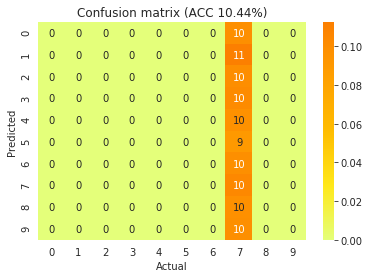

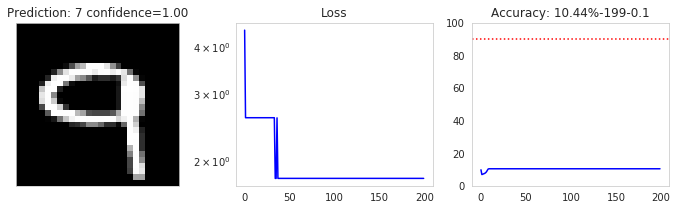

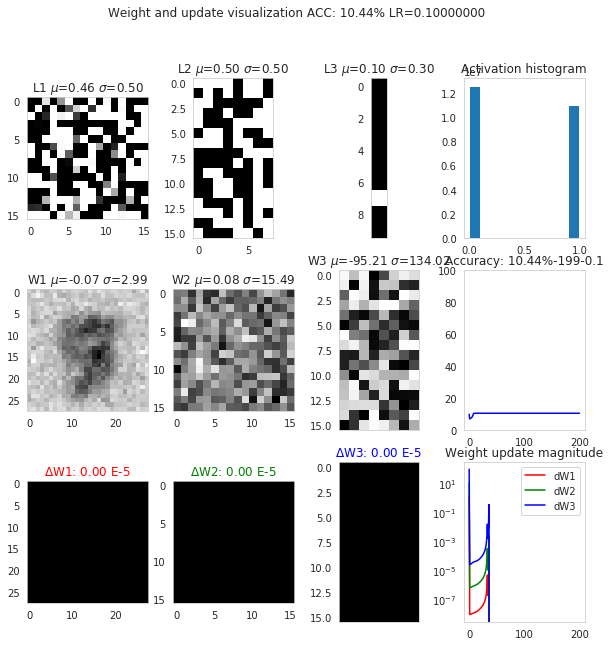

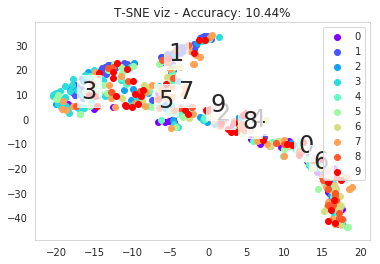

In [157]:
# Main loop
from IPython.display import clear_output
from tensorflow.keras.utils import Progbar
progbar = Progbar(200)

# Learning rate, decrease if optimization isn't working

learning_rate_array = [3e-5, 2e-5, 1e-5, 1e-3, 1e-1] # created list of learning rates to try
losses_dict = {} # create dictionary to store resulting loss for learning rate trials to plot with later
lr_accuracy_rate = {}


for j in range(len(learning_rate_array)):
    
    # set updated learning rate each loop
    lr = learning_rate_array[j]
    
    # reinitialize weights to random %% Setup: 784 -> 256 -> 128 -> 10
    W1 = 2*np.random.rand(784, 256).astype('float32').T - 1
    W2 = 2*np.random.rand(256, 128).astype('float32').T - 1
    W3 = 2*np.random.rand(128,  10).astype('float32').T - 1
    
    # reinitialize Monitoring variables to empty
    accuracies = []
    losses     = []
    mean_activ = []
    hw1, hw2, hw3 = [], [], []
    #progbar.update(i % 5)

    # optimize NN
    for i in range(200):
        L1, L2, L3    = forward_pass(X, W1, W2, W3)
        dW1, dW2, dW3 = backward_pass(L1, L2, L3, W1, W2, W3)
        W1, W2, W3    = update_weights(lr, W1, W2, W3, dW1, dW2, dW3, X, L1, L2)

        progbar.update(i % 200)
        calculate_loss()
        accuracy()
        hw_update()
        losses_dict[j] =losses #store losses for this round with the learning rate
        

        if i == 199:
            if checknan(L1) or checknan(L2) or checknan(L3):
                print('\nNaN encountered in activations. Try lowering the learning rate and/or correcting bugs in your code.')
                print('Optimization halted')
                break
            clear_output(wait=True)
            confusion_matrix()
            triple_plot()
            tsne_viz()
            lr_accuracy_rate[j] =accuracies #store losses for this round with the learning rate


## Problem 2.1: Learning Rate Line Chart

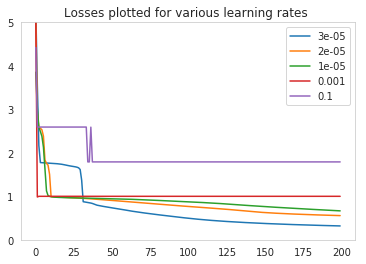

In [158]:
# plot all the different learning rates on 1 chart
for k in range(len(losses_dict)):
    line = plt.plot(losses_dict[k], label = str(learning_rate_array[k]))
    plt.title("Losses plotted for various learning rates ")
    plt.legend()
    plt.ylim(0,5)
plt.show()

# View Individual Charts
#for k in range(len(losses_dict)):
#    line = plt.plot(losses_dict[k], label = str(learning_rate_array[k]))
#    plt.title("Losses plotted for various learning rates ")
#    plt.legend()
#    plt.show()

## Problem 2.2: Learning Rate Bar Plot 

In [183]:
#list(chain(*lr_accuracy_rate.values()))

In [196]:
y_pos

array([0, 1, 2, 3, 4])

In [198]:
# bar plot of accuracy

import numpy as np
import matplotlib.pyplot as plt
from itertools import chain # library required to unchain

#height = list(chain(*lr_accuracy_rate.values())) # unchain the dictionary accuracy values
height = list(chain(*lr_accuracy_rate.values())) # unchain the dictionary accuracy values
bars =  (learning_rate_array[0],learning_rate_array[1],learning_rate_array[2],learning_rate_array[3],learning_rate_array[4])
y_pos = np.arange(len(bars))

x_labels = list(chain(*lr_accuracy_rate.values()))

plt.bar(y_pos, height[0:5])# Create bars
#ax = accuracy_dict.plot(kind='bar')
plt.xticks(y_pos, bars)# Create names on the x-axis
plt.xlabel('k value')
#plt.set_xticklabels(x_labels)
plt.ylabel('accuracy')
plt.title("Accuracy plotted for k parameters in sigmoid activation function ")


for i, v in enumerate(x_labels):
    plt.text(i, v, str(round(v))+"%", color='black', fontweight='bold')
    
plt.show() # Show graphic

In [167]:
learning_rate_array[4]

0.1

ValueError: shape mismatch: objects cannot be broadcast to a single shape

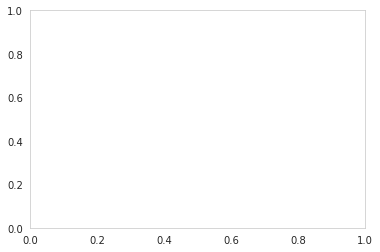

In [181]:
# bar plot of accuracy

import numpy as np
import matplotlib.pyplot as plt
from itertools import chain # library required to unchain

height = list(chain(*lr_accuracy_rate.values())) # unchain the dictionary accuracy values
bars =  (learning_rate_array[0],learning_rate_array[1],learning_rate_array[2],learning_rate_array[3],learning_rate_array[4])
y_pos = np.arange(len(bars))

x_labels = list(chain(*lr_accuracy_rate.values()))

plt.bar(y_pos, height)# Create bars
#ax = accuracy_dict.plot(kind='bar')
plt.xticks(y_pos, bars)# Create names on the x-axis
plt.xlabel('Learning Rate')
#plt.set_xticklabels(x_labels)
plt.ylabel('Accuracy')
plt.title("Accuracy plotted across learning rates ")


for i, v in enumerate(x_labels):
    plt.text(i, v, str(round(v))+"%", color='black', fontweight='bold')
    
plt.show() # Show graphic

# 2.2 Main loop - Activation Function

2 - Activation function: Try changing the sigmoid function to “1.0/(1.0 + np.e**-(k*x))”, 
where k is another training parameter. Explain what k does. 

What is the effect of a small k on training versus a larger value for k? 
Is there an optimal k for a given learning rate? Use the default learning rate “1e-5” for your experiments. 

Justify your position in words and show up to 5 plots.

### Updating sigmoid function

In [192]:
# Define basic sigmoid activation
def sigmoid(x): return 1.0/(1.0 + np.e**-x)

def sigmoid(x,k): return 1.0/(1.0 + np.e**-(k*x)) #sigmoid with k parameter

### Updating helperfunction to send in k parameter to sigmoid function

In [41]:
# update forward pass as it is using sigmoid
def forward_pass(X, W1, W2, W3, k):
    L1 = sigmoid(W1.dot(X), k)
    L2 = sigmoid(W2.dot(L1), k)
    L3 = sigmoid(W3.dot(L2), k)
    return L1, L2, L3

In [42]:
# update backward pass as it needs to include * by k because e^kx = ke^kx
def backward_pass(L1, L2, L3, W1, W2, W3, k):
    dW3 = (L3 - T) * L3*(1 - L3) * k
    dW2 = W3.T.dot(dW3)*(L2*(1-L2)) * k
    dW1 = W2.T.dot(dW2)*(L1*(1-L1)) * k
    return dW1, dW2, dW3

# 2.2 Main loop - Activation Function
## Best iteration = 1e^5 with 57% accuracy

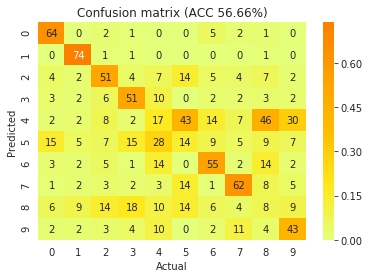

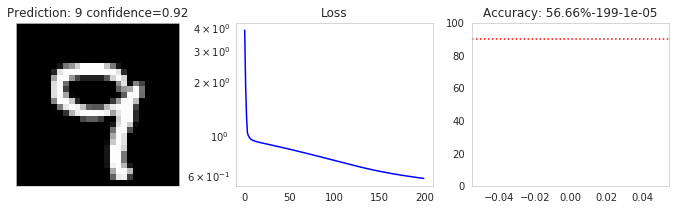

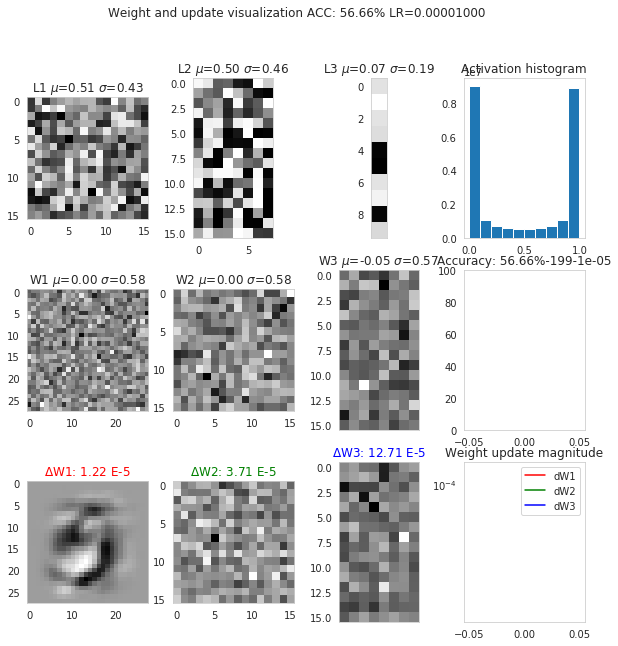

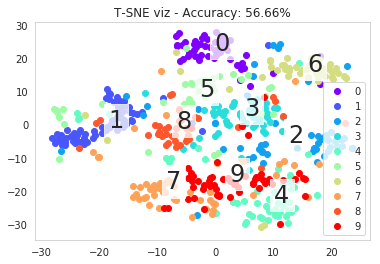

In [44]:
# Main loop
from IPython.display import clear_output
from tensorflow.keras.utils import Progbar
progbar = Progbar(200)

# Activation functions k parameter tuning
k_test_values = [.1, .4, .5, 1, 1.2]

# default learning rate = 1e-5
lr = 1e-5

# create dictionary to store resulting loss for activation rate trials to plot with later
losses_dict = {}

# create dictionary to store resulting accuracy for activation rate trials to plot with later
accuracy_dict = {}

for j in range(len(k_test_values)):

    # set k in each loop
    k = k_test_values[j]
    
    # reinitialize weights to random %% Setup: 784 -> 256 -> 128 -> 10
    W1 = 2*np.random.rand(784, 256).astype('float32').T - 1
    W2 = 2*np.random.rand(256, 128).astype('float32').T - 1
    W3 = 2*np.random.rand(128,  10).astype('float32').T - 1

    # reinitialize Monitoring variables to empty
    accuracies = []
    losses     = []
    mean_activ = []
    hw1, hw2, hw3 = [], [], []
    # progbar.update(i % 5)

    # optimize NN
    for i in range(200):
        L1, L2, L3    = forward_pass(X, W1, W2, W3, k)
        dW1, dW2, dW3 = backward_pass(L1, L2, L3, W1, W2, W3, k)
        W1, W2, W3    = update_weights(lr, W1, W2, W3, dW1, dW2, dW3, X, L1, L2)

        progbar.update(i % 200)
        calculate_loss()
        accuracy()
        hw_update()

        losses_dict[j] =losses #store losses for this round with the learning rate
        accuracy_dict[j] =accuracies #store losses for this round with the learning rate


        if i == 199:
            if checknan(L1) or checknan(L2) or checknan(L3):
                print('\nNaN encountered in activations. Try lowering the learning rate and/or correcting bugs in your code.')
                print('Optimization halted')
                break
            clear_output(wait=True)
            confusion_matrix()
            triple_plot()
            tsne_viz()

### Problem 2: Line Chart to determine which k parameter has the best loss

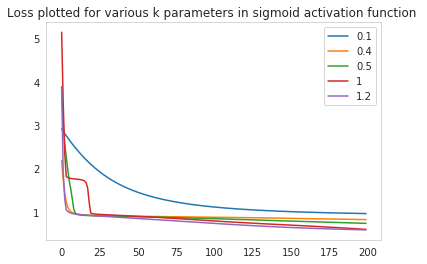

In [45]:
#plot all the different k parameters : k=.5 looks the best!
for m in range(len(k_test_values)):
    plt.plot(losses_dict[m], label = str(k_test_values[m]))
    plt.title("Loss plotted for various k parameters in sigmoid activation function ")
    plt.legend()
plt.show()


### Problem 2: Bar Plot to determine which k parameter has the highest accuracy


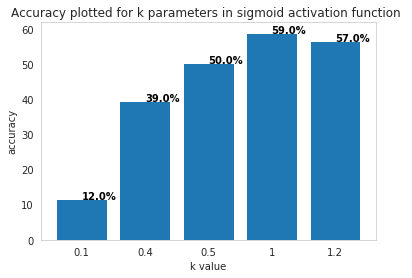

In [46]:
# bar plot of accuracy

import numpy as np
import matplotlib.pyplot as plt
from itertools import chain # library required to unchain

height = list(chain(*accuracy_dict.values())) # unchain the dictionary accuracy values
bars =  (k_test_values[0],k_test_values[1],k_test_values[2],k_test_values[3],k_test_values[4])
y_pos = np.arange(len(bars))

x_labels = list(chain(*accuracy_dict.values()))

plt.bar(y_pos, height)# Create bars
#ax = accuracy_dict.plot(kind='bar')
plt.xticks(y_pos, bars)# Create names on the x-axis
plt.xlabel('k value')
#plt.set_xticklabels(x_labels)
plt.ylabel('accuracy')
plt.title("Accuracy plotted for k parameters in sigmoid activation function ")


for i, v in enumerate(x_labels):
    plt.text(i, v, str(round(v))+"%", color='black', fontweight='bold')
    
plt.show() # Show graphic

In [ ]:
x_labels

In [ ]:
y_pos

In [ ]:
height

In [ ]:
hw3

## Problem 2.3: Initialization with sigmoid activation function

In [142]:
# Define basic sigmoid activation
def sigmoid(x): return 1.0/(1.0 + np.e**-x)

def sigmoid(x,k): return 1.0/(1.0 + np.e**-(k*x)) #sigmoid with k parameter

In [143]:
# update forward pass as it is using sigmoid
def forward_pass(X, W1, W2, W3, k):
    L1 = sigmoid(W1.dot(X), k)
    L2 = sigmoid(W2.dot(L1), k)
    L3 = sigmoid(W3.dot(L2), k)
    return L1, L2, L3

In [144]:
# update backward pass as it needs to include * by k because e^kx = ke^kx
def backward_pass(L1, L2, L3, W1, W2, W3, k):
    dW3 = (L3 - T) * L3*(1 - L3) * k
    dW2 = W3.T.dot(dW3)*(L2*(1-L2)) * k
    dW1 = W2.T.dot(dW2)*(L1*(1-L1)) * k
    return dW1, dW2, dW3

In [145]:
len(weights)

1

## Problem 2.3 Main loop - Initialize with Random, normal, uniform, and poisson

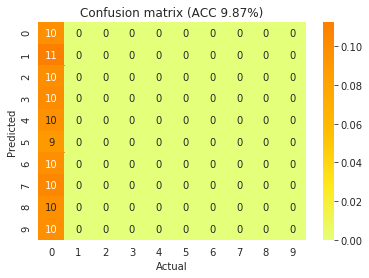

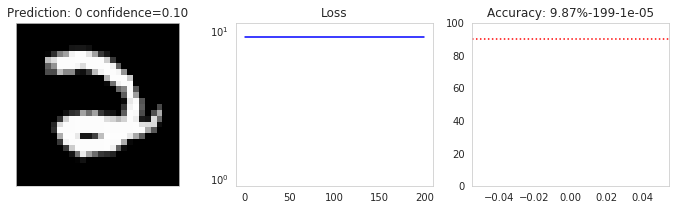

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


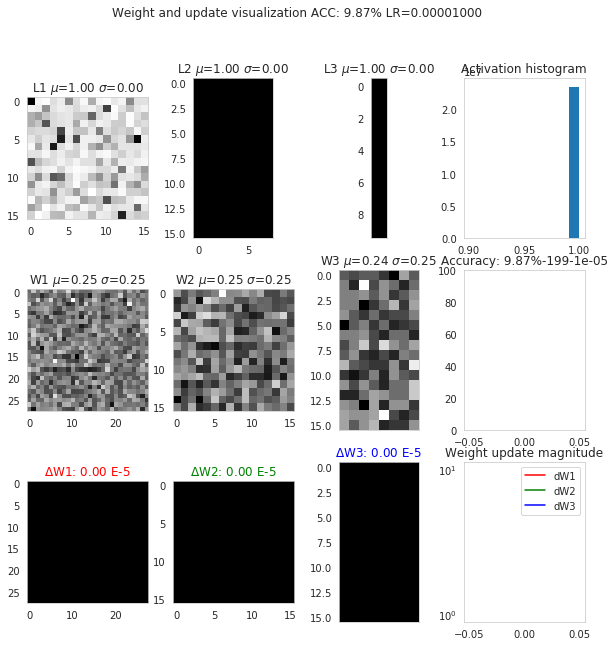

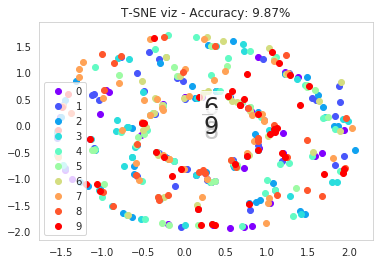

In [76]:
# Main loop
from IPython.display import clear_output
from tensorflow.keras.utils import Progbar
progbar = Progbar(200)

k=1 # optimal k
lr = 1e-5 # default learning rate = 1e-5

# create dictionary to store resulting loss for activation rate trials to plot with later
losses_dict = {}
# create dictionary to store resulting accuracy for activation rate trials to plot with later
accuracy_dict = {}

# Activation functions k parameter tuning
weights = ['random', 'normal', 'uniform', 'poisson']


for j in range(len(weights)):
    
    # reinitialize weights to random %% Setup: 784 -> 256 -> 128 -> 10
    if weights[j] == "random":
        W1 = 2*np.random.rand(784, 256).astype('float32').T - 1
        W2 = 2*np.random.rand(256, 128).astype('float32').T - 1
        W3 = 2*np.random.rand(128,  10).astype('float32').T - 1
    if weights[j] == "normal":
        W1 = (np.random.normal(loc=0, scale=1, size=(784, 256)).astype('float32').T)/3
        W2 = (np.random.normal(loc=0, scale=1, size=(256, 128)).astype('float32').T)/3
        W3 = (np.random.normal(loc=0, scale=1, size=(128,  10)).astype('float32').T)/3
    if weights[j] == "uniform":
        W1 = 2*np.random.rand(784, 256).astype('float32').T - 1
        W2 = 2*np.random.rand(256, 128).astype('float32').T - 1
        W3 = 2*np.random.rand(128,  10).astype('float32').T - 1
    if weights[j] == "poisson":
        W1 = (np.random.poisson(lam=1, size=(784, 256)).astype('float32').T)/4
        W2 = (np.random.poisson(lam=1, size=(256, 128)).astype('float32').T)/4
        W3 = (np.random.poisson(lam=1, size=(128,  10)).astype('float32').T)/4

    # reinitialize Monitoring variables to empty
    accuracies = []
    losses     = []
    mean_activ = []
    hw1, hw2, hw3 = [], [], []
    # progbar.update(i % 5)

    # optimize NN
    for i in range(200):
        L1, L2, L3    = forward_pass(X, W1, W2, W3, k)
        dW1, dW2, dW3 = backward_pass(L1, L2, L3, W1, W2, W3, k)
        W1, W2, W3    = update_weights(lr, W1, W2, W3, dW1, dW2, dW3, X, L1, L2)

        progbar.update(i % 200)
        calculate_loss()
        accuracy()
        hw_update()

        losses_dict[j] =losses #store losses for this round with the learning rate
        accuracy_dict[j] =accuracies #store losses for this round with the learning rate


        if i == 199:
            if checknan(L1) or checknan(L2) or checknan(L3):
                print('\nNaN encountered in activations. Try lowering the learning rate and/or correcting bugs in your code.')
                print('Optimization halted')
                break
            clear_output(wait=True)
            confusion_matrix()
            triple_plot()
            tsne_viz()

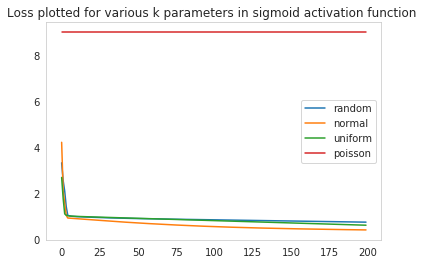

In [103]:
#plot all the different k parameters : k=.5 looks the best!
for m in range(len(weights)):
    plt.plot(losses_dict[m], label = str(weights[m]))
    plt.title("Loss plotted for various k parameters in sigmoid activation function ")
    plt.legend()
plt.show()

In [77]:
accuracy_dict

{0: [41.096666666666664],
 1: [78.515],
 2: [58.193333333333335],
 3: [9.871666666666666]}

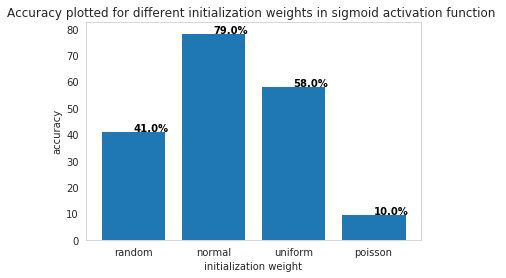

In [80]:
# bar plot of accuracy

import numpy as np
import matplotlib.pyplot as plt
from itertools import chain # library required to unchain

height = list(chain(*accuracy_dict.values())) # unchain the dictionary accuracy values
bars =  (weights[0],weights[1],weights[2],weights[3])
y_pos = np.arange(len(bars))

x_labels = list(chain(*accuracy_dict.values()))

plt.bar(y_pos, height)# Create bars
#ax = accuracy_dict.plot(kind='bar')
plt.xticks(y_pos, bars)# Create names on the x-axis
plt.xlabel('initialization weight')
#plt.set_xticklabels(x_labels)
plt.ylabel('accuracy')
plt.title("Accuracy plotted for different initialization weights in sigmoid activation function ")


for i, v in enumerate(x_labels):
    plt.text(i, v, str(round(v))+"%", color='black', fontweight='bold')
    
plt.show() # Show graphic

## Problem 2.3 Main loop - Initialize with random.rand(size1, size2).T * sqrt(2/(size1+size2))

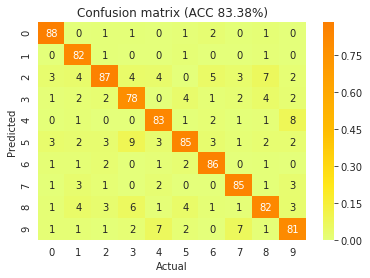

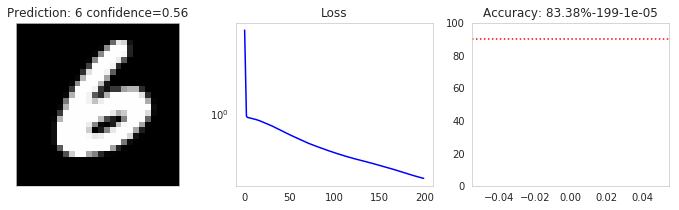

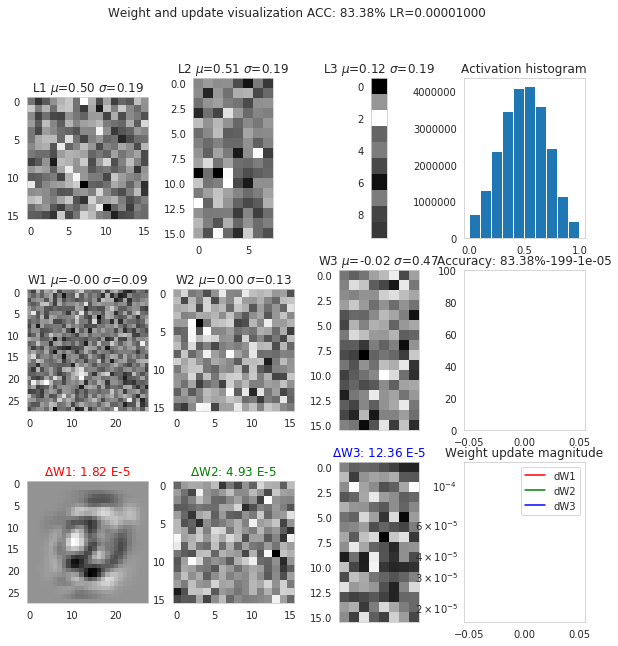

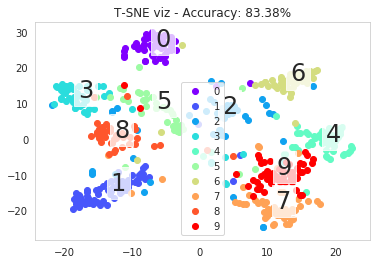

In [146]:
# Main loop
from IPython.display import clear_output
from tensorflow.keras.utils import Progbar
progbar = Progbar(200)

# Activation functions k parameter tuning
k= 1

# default learning rate = 1e-5
lr = 1e-5

# create dictionary to store resulting loss for activation rate trials to plot with later
sqrt_initialization_losses_dict = []

# create dictionary to store resulting accuracy for activation rate trials to plot with later
sqrt_initialization_accuracy_dict = []


# Activation functions k parameter tuning
weights = ['randomSqrt']#, 'smallNumbers','zero']


for j in range(len(weights)):
    
    # reinitialize weights to random %% Setup: 784 -> 256 -> 128 -> 10
    if weights[j] == "randomSqrt":
        # initialize with random - all the weights randomly from a univariate “Gaussian” (Normal) distribution having mean 0 and variance 1 
        # and multiply them by a negative power of 10 to make them small. 
        W1 = np.random.randn(784, 256).T*np.sqrt(2/256)
        W2 = np.random.randn(256, 128).T*np.sqrt(2/128)
        W3 = np.random.randn(128, 10).T*np.sqrt(2/10)
    if weights[j] == "smallNumbers":
        W1 = np.random.randn(0, 1)
        W2 = np.random.randn(0, 1)
        W3 = np.random.randn(0, 1)
    if weights[j] == "zero":
        W1 = np.random.randn(0, 0)
        W2 = np.random.randn(0, 0)
        W3 = np.random.randn(0, 0)



    # reinitialize Monitoring variables to empty
    accuracies = []
    losses     = []
    mean_activ = []
    hw1, hw2, hw3 = [], [], []
    # progbar.update(i % 5)

    # optimize NN
    for i in range(200):
        L1, L2, L3    = forward_pass(X, W1, W2, W3, k)
        dW1, dW2, dW3 = backward_pass(L1, L2, L3, W1, W2, W3, k)
        W1, W2, W3    = update_weights(lr, W1, W2, W3, dW1, dW2, dW3, X, L1, L2)

        progbar.update(i % 200)
        calculate_loss()
        accuracy()
        hw_update()

        sqrt_initialization_losses_dict =losses #store losses for this round with the learning rate
        sqrt_initialization_accuracy_dict =accuracies #store losses for this round with the learning rate


        if i == 199:
            if checknan(L1) or checknan(L2) or checknan(L3):
                print('\nNaN encountered in activations. Try lowering the learning rate and/or correcting bugs in your code.')
                print('Optimization halted')
                break
            clear_output(wait=True)
            confusion_matrix()
            triple_plot()
            tsne_viz()

In [150]:
accuracies


[83.37833333333333]

In [187]:
weights

['randomSqrt']

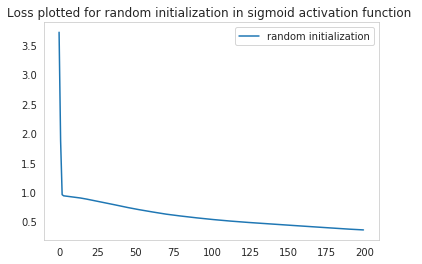

In [189]:
#plot all the different k parameters : k=.5 looks the best!
plt.plot(sqrt_initialization_losses_dict, label = "random initialization")
plt.title("Loss plotted for random initialization in sigmoid activation function ")
plt.legend()
plt.show()


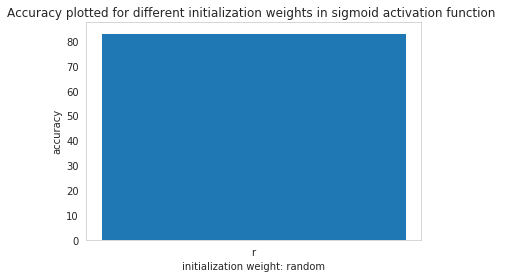

In [165]:
# bar plot of accuracy

import numpy as np
import matplotlib.pyplot as plt
from itertools import chain # library required to unchain

height = accuracies # unchain the dictionary accuracy values
bars =  "randomly assigned"
y_pos = np.arange(len(weights))

x_labels = "randomly assigned"

plt.bar(y_pos, height)# Create bars
#ax = accuracy_dict.plot(kind='bar')
plt.xticks(y_pos, bars)# Create names on the x-axis
plt.xlabel('initialization weight: random')
#plt.set_xticklabels(x_labels)
plt.ylabel('accuracy')
plt.title("Accuracy plotted for different initialization weights in sigmoid activation function ")



plt.show() # Show graphic

# Problem 3.1: Activations and Gradients: 
### Examine the activations and gradients visualized during training. Justify why the activation and gradient matrices are “optimal” or not. Propose some ways to “fix” the activations/gradients to improve training. Show some plots to illustrate how your proposed “fix” improves training.


In [194]:
# Define basic sigmoid activation
#def sigmoid(x): return 1.0/(1.0 + np.e**-x)
#def sigmoid(x,k): return 1.0/(1.0 + np.e**-(k*x)) #sigmoid with k parameter


def relu(x): return np.maximum(x, 0)

def lrelu(x, alpha=0.01):
    return np.maximum(alpha*x, x)

def softmax(X):
    exps = np.exp(X)
    return exps / np.sum(exps, axis=0)


## Problem 3.2 Main - Tanh
### random.rand(size1, size2).T * sqrt2(1(size1+size2))
-Tanh with k = 1, learning rate = 1e-5, 25%

In [70]:
# tanh
# Define new activation functions
def than(x): return np.tanh(x)

def forward_pass(X, W1, W2, W3):
    L1 = np.tanh(W1.dot(X))
    L2 = np.tanh(W2.dot(L1))
    L3 = np.tanh(W3.dot(L2))
    return L1, L2, L3
# update backward pass 
def backward_pass(L1, L2, L3, W1, W2, W3):
    dW3 = (L3 - T) * (1 - L3**2)
    dW2 = W3.T.dot(dW3)*(1 - L2**2)
    dW1 = W2.T.dot(dW2)*(1 - L1**2)
    return dW1, dW2, dW3

In [200]:
# Main loop
from IPython.display import clear_output
from tensorflow.keras.utils import Progbar
progbar = Progbar(200)

k=1 

# default learning rate = 1e-5
lr = 1e-5

# create dictionary to store resulting loss for activation rate trials to plot with later
losses_dict = {}

# create dictionary to store resulting accuracy for activation rate trials to plot with later
accuracy_dict = {}

# Normal distribution std = 1/sqrt(Layer size)
#W1 = np.random.normal(0, 1, [784, 256]).astype('float32').T /np.sqrt(784)
#W2 = np.random.normal(0, 1, [256, 128]).astype('float32').T /np.sqrt(256)
#W3 = np.random.normal(0, 1, [128,  10]).astype('float32').T /np.sqrt(128)

W1 = np.random.randn(784, 256).T*np.sqrt(1/(256+784))
W2 = np.random.randn(256, 128).T*np.sqrt(1/(128+256))
W3 = np.random.randn(128, 10).T*np.sqrt(1/(10+128))
        
# reinitialize Monitoring variables to empty
accuracies = []
losses     = []
mean_activ = []
hw1, hw2, hw3 = [], [], []
# progbar.update(i % 5)

# optimize NN
for i in range(200):
    L1, L2, L3    = forward_pass(X, W1, W2, W3)
    dW1, dW2, dW3 = backward_pass(L1, L2, L3, W1, W2, W3)
    W1, W2, W3    = update_weights(lr, W1, W2, W3, dW1, dW2, dW3, X, L1, L2)

    progbar.update(i % 200)
    calculate_loss()
    accuracy()
    hw_update()


    if i == 199:
        if checknan(L1) or checknan(L2) or checknan(L3):
            print('\nNaN encountered in activations. Try lowering the learning rate and/or correcting bugs in your code.')
            print('Optimization halted')
            break
        clear_output(wait=True)
        confusion_matrix()
        triple_plot()
        tsne_viz()
        
        #losses_dict[j] =losses #store losses for this round with the learning rate
        #accuracy_dict[j] =accuracies #store losses for this round with the learning rate


  3/200 [..............................] - ETA: 38:45

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 12, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt: 
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-200-30333c1421ea>", line 35, in <module>
    L1, L2, L3    = forward_pass(X, W1, W2, W3)
  File "<ipython-input-144-680899dca2ad>", line 3, in forward_pass
    L2 = sigmoid(W2.dot(L1))
  File "<ipython-input-143-e6e6bc929c8c>", line 2, in sigmoid
    def sigmoid(x): return 1.0/(1.0 + np.e**-x)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 1863, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/l

KeyboardInterrupt: 

In [ ]:
losses

In [ ]:
accuracies

## Problem 3.3 Main - Cross entropy implementation

In [65]:
# sigmoid with cross entropy

# Define basic sigmoid activation
def sigmoid(x): return 1.0/(1.0 + np.e**-x)
#def sigmoid(x,k): return 1.0/(1.0 + np.e**-(k*x)) #sigmoid with k parameter

def sigmoid_cross_entrophy_forward(X, W1, W2, W3):
    # Forward pass
    L1 = sigmoid(W1.dot(X))
    L2 = sigmoid(W2.dot(L1))
    L3 = sigmoid(W3.dot(L2))
    return L1, L2, L3

def sigmoid_cross_entrophy_backward(L1, L2, L3, W1, W2, W3):
    # Backward pass
    dW3 = (L3 - T)
    dW2 = W3.T.dot(dW3)*(L2*(1-L2))
    dW1 = W2.T.dot(dW2)*(L1*(1-L1))
    return dW1, dW2, dW3

In [199]:
# Main loop
from IPython.display import clear_output
from tensorflow.keras.utils import Progbar
progbar = Progbar(200)

k=1 

# default learning rate = 1e-5
lr = 1e-5

# create dictionary to store resulting loss for activation rate trials to plot with later
losses_dict = {}

# create dictionary to store resulting accuracy for activation rate trials to plot with later
accuracy_dict = {}

# Best distribution for Relu activation functions 
# Normal distribution std = 1/sqrt(Layer size)
W1 = np.random.normal(0, 1, [784, 256]).astype('float32').T /np.sqrt(784)
W2 = np.random.normal(0, 1, [256, 128]).astype('float32').T /np.sqrt(256)
W3 = np.random.normal(0, 1, [128,  10]).astype('float32').T /np.sqrt(128)

# reinitialize Monitoring variables to empty
accuracies = []
losses     = []
mean_activ = []
hw1, hw2, hw3 = [], [], []
# progbar.update(i % 5)
temp_accuracies = []

# optimize NN
for i in range(200):
    L1, L2, L3    = sigmoid_cross_entrophy_forward(X, W1, W2, W3)
    dW1, dW2, dW3 = sigmoid_cross_entrophy_backward(L1, L2, L3, W1, W2, W3)
    W1, W2, W3    = update_weights(lr, W1, W2, W3, dW1, dW2, dW3, X, L1, L2)

    progbar.update(i % 200)
    calculate_loss()
    #cross_entropy()
    accuracy()
    hw_update()


    if i == 199:
        if checknan(L1) or checknan(L2) or checknan(L3):
            print('\nNaN encountered in activations. Try lowering the learning rate and/or correcting bugs in your code.')
            print('Optimization halted')
            break
        clear_output(wait=True)
        confusion_matrix()
        triple_plot()
        tsne_viz()
        
        losses_dict =losses #store losses for this round with the learning rate
        accuracy_dict =accuracies #store losses for this round with the learning rate

  0/200 [..............................] - ETA: 0s

KeyboardInterrupt: 

In [ ]:
#plot all the different k parameters : k=.5 looks the best!
plt.plot(losses, label = "Losses")
plt.title("Losses for Relu with Normal dist ")
plt.legend()
plt.show()

In [ ]:
#plot all the different k parameters : k=.5 looks the best!
plt.plot(accuracy, label = "accuracy")
plt.title("Accuracy for Relu with Normal dist ")
plt.legend()
plt.show()

## Problem 3.4 Main - relu

In [54]:
# relu
def relu(x): return np.maximum(x, 0)
def drelu(x): return 1. * (x>0)


def forward_pass_relu(X, W1, W2, W3):
    # Forward pass
    L1 = relu(W1.dot(X))
    L2 = relu(W2.dot(L1))
    L3 = relu(W3.dot(L2))
    return L1, L2, L3

def backward_pass_relu(L1, L2, L3, W1, W2, W3):
    # Backward pass
    dW3 = (L3 - T) * drelu(L3)
    dW2 = W3.T.dot(dW3) * drelu(L2)
    dW1 = W2.T.dot(dW2) * drelu(L1)
    return dW1, dW2, dW3

In [55]:
# update loss function for cross entrophy 
#def cross_entropy():
#    loss = np.sum(- np.dot(T, np.log(L3).T) - np.dot(1-T, np.log(1-L3).T))/len(T.T)
#    losses.append(loss)
#    print("[%04d] cross entropy Loss: %0.6f" % (i, loss))

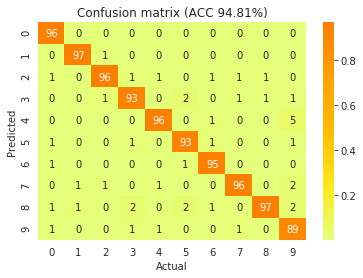

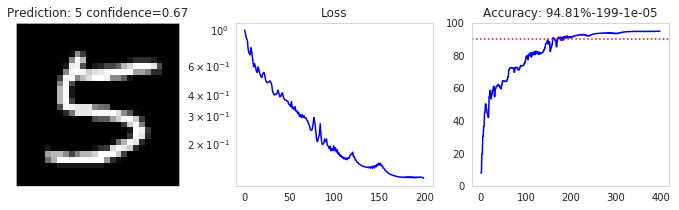

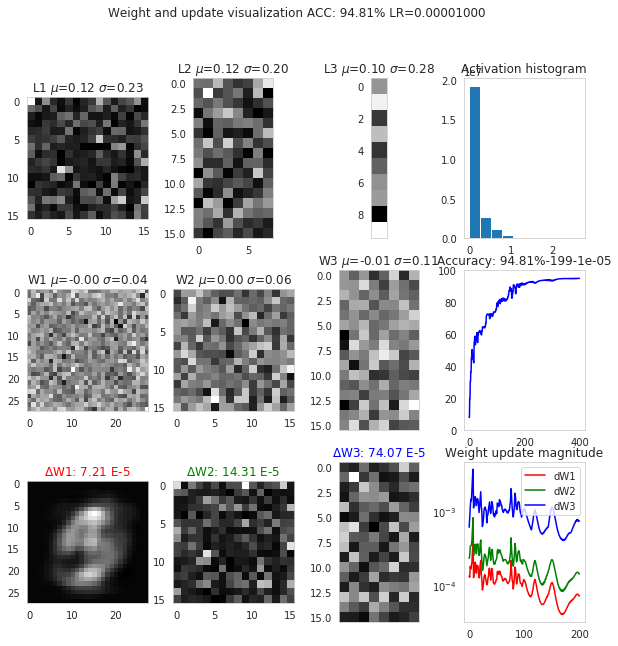

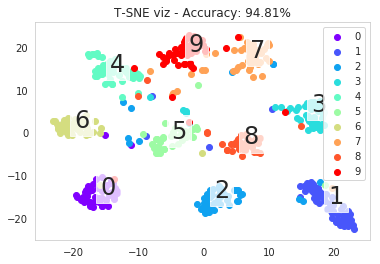

In [56]:
# Main loop
from IPython.display import clear_output
from tensorflow.keras.utils import Progbar
progbar = Progbar(200)

k=1 

# default learning rate = 1e-5
lr = 1e-5

# create dictionary to store resulting loss for activation rate trials to plot with later
losses_dict = {}

# create dictionary to store resulting accuracy for activation rate trials to plot with later
accuracy_dict = {}

# Best distribution for Relu activation functions 
# Normal distribution std = 1/sqrt(Layer size)
W1 = np.random.normal(0, 1, [784, 256]).astype('float32').T /np.sqrt(784)
W2 = np.random.normal(0, 1, [256, 128]).astype('float32').T /np.sqrt(256)
W3 = np.random.normal(0, 1, [128,  10]).astype('float32').T /np.sqrt(128)

# reinitialize Monitoring variables to empty
accuracies = []
losses     = []
mean_activ = []
hw1, hw2, hw3 = [], [], []
# progbar.update(i % 5)
temp_accuracies = []

# optimize NN
for i in range(200):
    L1, L2, L3    = forward_pass_relu(X, W1, W2, W3)
    dW1, dW2, dW3 = backward_pass_relu(L1, L2, L3, W1, W2, W3)
    W1, W2, W3    = update_weights(lr, W1, W2, W3, dW1, dW2, dW3, X, L1, L2)

    progbar.update(i % 200)
    calculate_loss()
    #cross_entropy()
    accuracy()
    hw_update()

    losses_dict[i] =losses #store losses for this round with the learning rate
    accuracy_dict[i] =accuracies #store losses for this round with the learning rate
    accuracy()


    if i == 199:
        if checknan(L1) or checknan(L2) or checknan(L3):
            print('\nNaN encountered in activations. Try lowering the learning rate and/or correcting bugs in your code.')
            print('Optimization halted')
            break
        clear_output(wait=True)
        confusion_matrix()
        triple_plot()
        tsne_viz()

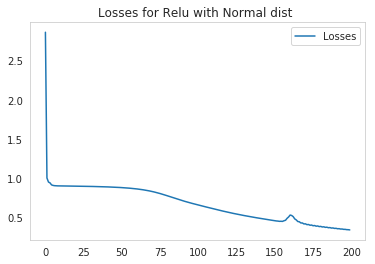

In [67]:
#plot all the different k parameters : k=.5 looks the best!
plt.plot(losses, label = "Losses")
plt.title("Losses for Relu with Normal dist ")
plt.legend()
plt.show()

In [ ]:
#plot all the different k parameters : k=.5 looks the best!
plt.plot(accuracy, label = "accuracy")
plt.title("Accuracy for Relu with Normal dist ")
plt.legend()
plt.show()

## Problem 3.1 Main - relu6


In [72]:
def relu6(x):
    maxVal = x * (x > 0)
    maxVal[maxVal>=6]=6
    return maxVal

def forward_pass_relu6(X, W1, W2, W3):
    L1 = relu6(W1.dot(X))
    L2 = relu6(W2.dot(L1))
    L3 = relu6(W3.dot(L2))
    return L1, L2, L3

def backward_pass_relu6(L1, L2, L3, W1, W2, W3):
    dW3 = (L3 - T) * 1. * ((L3 > 0) * (L3 < 6))
    dW2 = W3.T.dot(dW3) * 1. * ((L2 > 0) * (L2 < 6))
    dW1 = W2.T.dot(dW2) * 1. * ((L1 > 0) * (L1 < 6))
    return dW1, dW2, dW3

In [47]:
# update loss function for cross entrophy 
#def cross_entropy():
#    loss = np.sum(- np.dot(T, np.log(L3).T) - np.dot(1-T, np.log(1-L3).T))/len(T.T)
#    losses.append(loss)
#    print("[%04d] cross entropy Loss: %0.6f" % (i, loss))

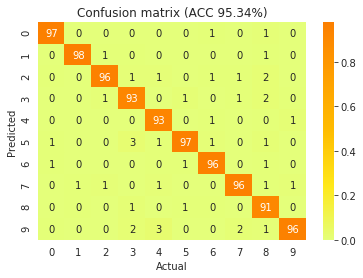

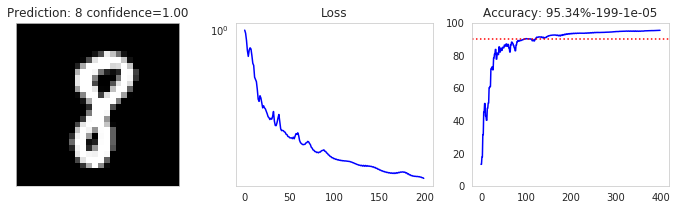

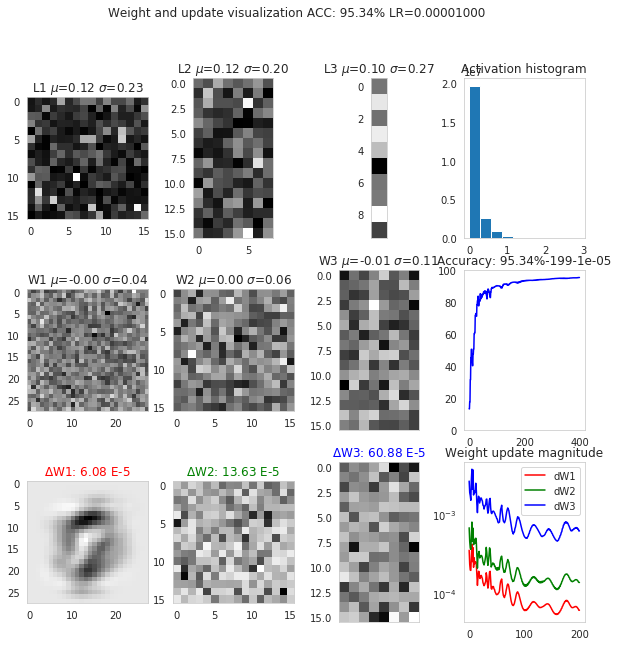

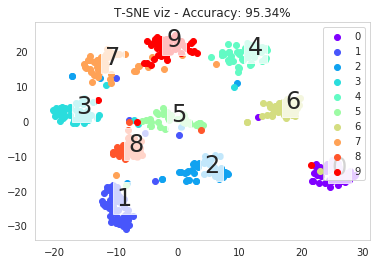

In [73]:
# Main loop
from IPython.display import clear_output
from tensorflow.keras.utils import Progbar
progbar = Progbar(200)

k=1 

# default learning rate = 1e-5
lr = 1e-5

# create dictionary to store resulting loss for activation rate trials to plot with later
losses_dict = {}

# create dictionary to store resulting accuracy for activation rate trials to plot with later
accuracy_dict = {}

# Normal distribution std = 1/sqrt(Layer size)
W1 = np.random.normal(0, 1, [784, 256]).astype('float32').T /np.sqrt(784)
W2 = np.random.normal(0, 1, [256, 128]).astype('float32').T /np.sqrt(256)
W3 = np.random.normal(0, 1, [128,  10]).astype('float32').T /np.sqrt(128)

# reinitialize Monitoring variables to empty
accuracies = []
losses     = []
mean_activ = []
hw1, hw2, hw3 = [], [], []
# progbar.update(i % 5)
temp_accuracies = []

# optimize NN
for i in range(200):
    L1, L2, L3    = forward_pass_relu6(X, W1, W2, W3)
    dW1, dW2, dW3 = backward_pass_relu6(L1, L2, L3, W1, W2, W3)
    W1, W2, W3    = update_weights(lr, W1, W2, W3, dW1, dW2, dW3, X, L1, L2)

    progbar.update(i % 200)
    calculate_loss()
    #cross_entropy()
    accuracy()
    hw_update()

    losses_dict[i] =losses #store losses for this round with the learning rate
    accuracy_dict[i] =accuracies #store losses for this round with the learning rate
    accuracy()


    if i == 199:
        if checknan(L1) or checknan(L2) or checknan(L3):
            print('\nNaN encountered in activations. Try lowering the learning rate and/or correcting bugs in your code.')
            print('Optimization halted')
            break
        clear_output(wait=True)
        confusion_matrix()
        triple_plot()
        tsne_viz()

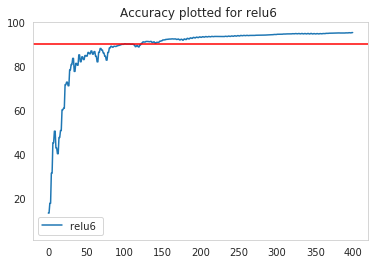

In [89]:
#plot all the different k parameters : k=.5 looks the best!
plt.plot(accuracies, label = "relu6 ")
plt.title("Accuracy plotted for relu6 ")
plt.legend()
plt.axhline(90, color="red")
#plt.abs(90)
plt.ylim(1,100)
plt.show()

In [100]:
len(list(chain(*accuracy_dict.values())))

80000

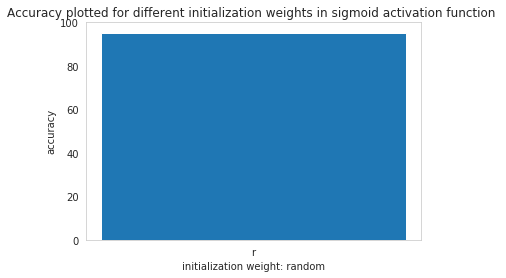

In [105]:
# bar plot of accuracy

import numpy as np
import matplotlib.pyplot as plt
from itertools import chain # library required to unchain

height = list(chain(*accuracy_dict.values()))[len(list(chain(*accuracy_dict.values())))-1] # unchain the dictionary accuracy values
bars =  "r"
y_pos = np.arange(len(bars))

x_labels = "randomly assigned"

plt.bar(y_pos, height)# Create bars
#ax = accuracy_dict.plot(kind='bar')
plt.xticks(y_pos, bars)# Create names on the x-axis
plt.xlabel('initialization weight: random')
#plt.set_xticklabels(x_labels)
plt.ylabel('accuracy')
plt.title("Accuracy plotted for different initialization weights in sigmoid activation function ")



plt.show() # Show graphic

ValueError: shape mismatch: objects cannot be broadcast to a single shape

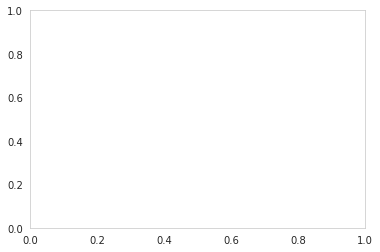

In [94]:
# bar plot of accuracy

import numpy as np
import matplotlib.pyplot as plt
from itertools import chain # library required to unchain

height = list(chain(*accuracy_dict.values())) # unchain the dictionary accuracy values
bars = "relu"
y_pos = np.arange(len(bars))

x_labels = list(chain(*accuracy_dict.values()))

plt.bar(y_pos, height)# Create bars
#ax = accuracy_dict.plot(kind='bar')
plt.xticks(y_pos, bars)# Create names on the x-axis
plt.xlabel('initialization weight')
#plt.set_xticklabels(x_labels)
plt.ylabel('accuracy')
plt.title("Accuracy plotted for different initialization weights in sigmoid activation function ")


plt.show() # Show graphic

## Problem 3.1 Main - relu6 with cross entrophy

## Original Main Loop as Reference

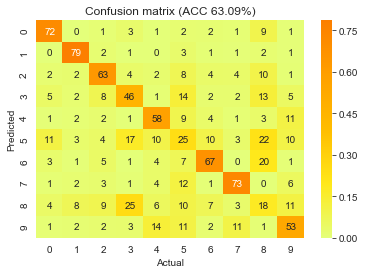

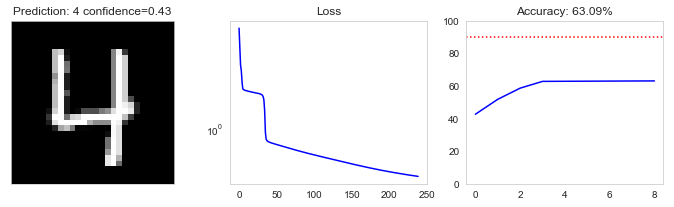

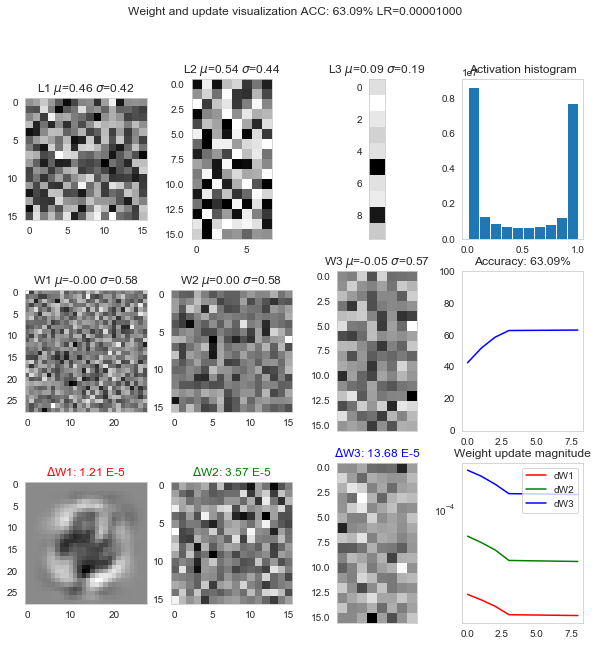

KeyboardInterrupt: 

In [20]:
# Main loop
from IPython.display import clear_output
from tensorflow.keras.utils import Progbar
progbar = Progbar(50)

# Learning rate, decrease if optimization isn't working
lr = 1e-5

for i in range(50):
    L1, L2, L3    = forward_pass(X, W1, W2, W3)
    dW1, dW2, dW3 = backward_pass(L1, L2, L3, W1, W2, W3)
    W1, W2, W3    = update_weights(lr, W1, W2, W3, dW1, dW2, dW3, X, L1, L2)
    
    progbar.update(i % 50)
    calculate_loss()

  #  if i % 50 == 49:
    if checknan(L1) or checknan(L2) or checknan(L3):
        print('\nNaN encountered in activations. Try lowering the learning rate and/or correcting bugs in your code.')
        print('Optimization halted')
        break
    clear_output(wait=True)
    confusion_matrix()
    triple_plot()
    tsne_viz()